## Download Data

In [1]:
# Khoa_LHR_image.zip
!gdown --id 1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3



/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3
From (redirected): https://drive.google.com/uc?id=1bsWkNmmYvBrgE1c58SGJFcCjQv3SUyH3&confirm=t&uuid=12c07cd6-fbf5-445a-90af-d707b46cdb90
To: /content/Khoa_LHR_image.zip
100% 89.0M/89.0M [00:00<00:00, 103MB/s]


In [2]:
!pip install torcheval


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.5 MB/s eta 0:00:00


In [3]:
!unzip /content/Khoa_LHR_image.zip

Archive:  /content/Khoa_LHR_image.zip
   creating: Khoa_LHR_image/
   creating: Khoa_LHR_image/train/
  inflating: Khoa_LHR_image/train/0.png  
  inflating: Khoa_LHR_image/train/1.png  
  inflating: Khoa_LHR_image/train/10.png  
  inflating: Khoa_LHR_image/train/100.png  
  inflating: Khoa_LHR_image/train/101.png  
  inflating: Khoa_LHR_image/train/102.png  
  inflating: Khoa_LHR_image/train/103.png  
  inflating: Khoa_LHR_image/train/104.png  
  inflating: Khoa_LHR_image/train/105.png  
  inflating: Khoa_LHR_image/train/106.png  
  inflating: Khoa_LHR_image/train/107.png  
  inflating: Khoa_LHR_image/train/108.png  
  inflating: Khoa_LHR_image/train/109.png  
  inflating: Khoa_LHR_image/train/11.png  
  inflating: Khoa_LHR_image/train/110.png  
  inflating: Khoa_LHR_image/train/111.png  
  inflating: Khoa_LHR_image/train/112.png  
  inflating: Khoa_LHR_image/train/113.png  
  inflating: Khoa_LHR_image/train/114.png  
  inflating: Khoa_LHR_image/train/115.png  
  inflating: Khoa_LHR_im

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torcheval.metrics.functional import peak_signal_noise_ratio
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(66)


## Problem 2: Super Resolution with UNET

In [5]:
LHR_TRAIN_DATA_PATH = '/content/Khoa_LHR_image/train'
LHR_VAL_DATA_PATH = '/content/Khoa_LHR_image/val'
BATCH_SIZE = 8
LOW_IMG_HEIGHT = 64
LOW_IMG_WIDTH = 64

### Unet for Super Resolution Task

#### No skip connection

In [6]:
class FirstFeatureNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeatureNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlockNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlockNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class EncoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(EncoderNoSkip, self).__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlockNoSkip(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlockNoSkip(out_channels*2, out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_block(x)
        return x


class FinalOutputNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutputNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class SR_Unet_NoSkip(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3
    ):
        super(SR_Unet_NoSkip, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_IMG_HEIGHT*4, LOW_IMG_HEIGHT*4),
                                             antialias=True)
        self.in_conv1 = FirstFeatureNoSkip(n_channels, 64)
        self.in_conv2 = ConvBlockNoSkip(64, 64)

        self.enc_1 = EncoderNoSkip(64, 128)
        self.enc_2 = EncoderNoSkip(128, 256)
        self.enc_3 = EncoderNoSkip(256, 512)
        self.enc_4 = EncoderNoSkip(512, 1024)

        self.dec_1 = DecoderNoSkip(1024, 512)
        self.dec_2 = DecoderNoSkip(512, 256)
        self.dec_3 = DecoderNoSkip(256, 128)
        self.dec_4 = DecoderNoSkip(128, 64)

        self.out_conv = FinalOutputNoSkip(64, n_classes)


    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        x = self.enc_4(x)

        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)

        x = self.out_conv(x)
        return x

In [7]:
unet_model = SR_Unet_NoSkip().to(device)
img = torch.ones(2, 3, 64, 64).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

#### Skip connection

In [8]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class SR_Unet(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3
    ):
        super(SR_Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_IMG_HEIGHT*4, LOW_IMG_HEIGHT*4),
                                             antialias=True)
        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)


    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x1 = self.in_conv2(x)

        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)

        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)

        x = self.out_conv(x)
        return x

In [9]:
unet_model = SR_Unet().to(device)
img = torch.ones(2, 3, 64, 64).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

### Prepare Super Resolution Dataset

#### Split Tran Validation data

In [10]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.resize = transforms.Resize((LOW_IMG_HEIGHT, LOW_IMG_WIDTH),antialias=True)
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def normalize(self, input_image, target_image):
        input_image = input_image * 2 -1
        target_image = target_image * 2 -1
        return input_image, target_image


    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_range = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = np.array(Image.open(img_path).convert("RGB"))
        image = transforms.functional.to_tensor(image)

        input_image = self.resize(image).type(torch.float32)
        target_image = image.type(torch.float32)

        input_image, target_image = self.normalize(input_image, target_image)

        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image


In [11]:
train_dataset = ImageDataset(LHR_TRAIN_DATA_PATH, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageDataset(LHR_VAL_DATA_PATH, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Text(0.5, 1.0, 'Target')

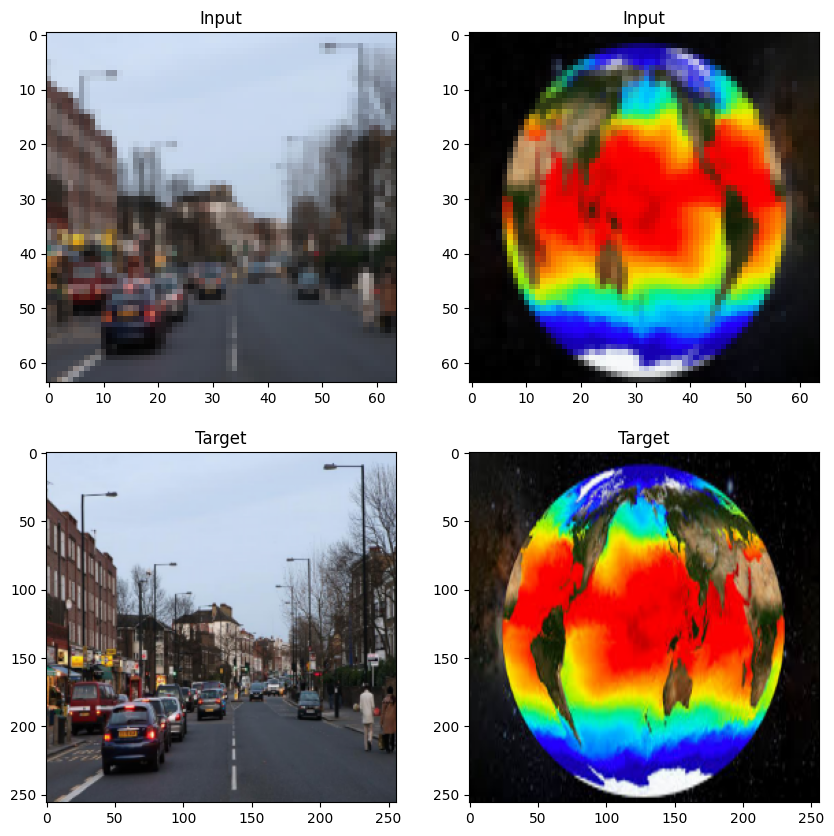

In [12]:
in_batch, tar_batch = next(iter(train_loader))
in_batch = (in_batch + 1)/2
tar_batch = (tar_batch + 1)/2

plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(in_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(tar_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Target")
ax = plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(in_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(tar_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Target")



### Train

In [13]:
def generate_images(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
    inputs, labels, predictions = inputs.cpu().numpy(), labels.cpu().numpy(), predictions.cpu().numpy()
    plt.figure(figsize=(15,20))

    display_list = [inputs[-1].transpose((1, 2, 0)), labels[-1].transpose((1, 2, 0)), predictions[-1].transpose((1, 2, 0))]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [14]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0,
                log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(predictions, labels)
        total_count += 1
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| psnr {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0
            start_time = time.time()

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [15]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())


            total_psnr +=  peak_signal_noise_ratio(predictions, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [16]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_psnr, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_psnrs.append(train_psnr.cpu())
        train_losses.append(train_loss)

        # Evaluation
        eval_psnr, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_psnrs.append(eval_psnr.cpu())
        eval_losses.append(eval_loss)

        # Save best model
        if best_psnr_eval < eval_psnr :
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')
            inputs_t, targets_t = next(iter(valid_dataloader))
            generate_images(model, inputs_t, targets_t)
            best_psnr_eval = eval_psnr
        times.append(time.time() - epoch_start_time)
        # Print loss, psnr end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [17]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_psnrs, eval_psnrs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_psnrs, label = "Training")
    axs[0].plot(epochs, eval_psnrs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("PSNR")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [18]:
import matplotlib.pyplot as plt

def predict_and_display(model, test_dataloader, device):
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            if idx >= 10:
                break
            inputs = inputs.to(device)
            predictions = model(inputs)
            generate_images(model, inputs, labels)
            plt.show()




#### Unet No Skip Connection


| epoch   1 |    50/   86 batches | psnr   12.711


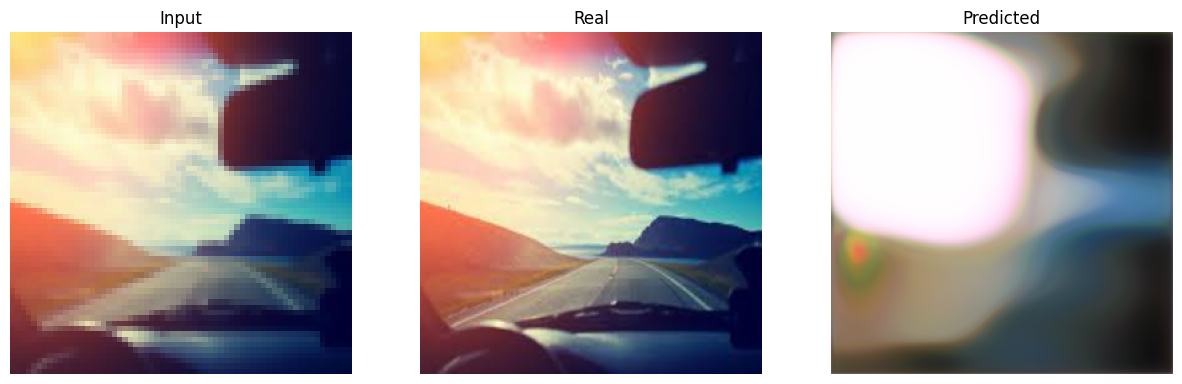

-----------------------------------------------------------
| End of epoch   1 | Time: 58.06s | Train psnr   13.269 | Train Loss    0.336 | Valid psnr   15.681 | Valid Loss    0.231 
-----------------------------------------------------------
| epoch   2 |    50/   86 batches | psnr   13.325
-----------------------------------------------------------
| End of epoch   2 | Time: 57.03s | Train psnr   13.635 | Train Loss    0.309 | Valid psnr   12.742 | Valid Loss    0.311 
-----------------------------------------------------------
| epoch   3 |    50/   86 batches | psnr   13.885


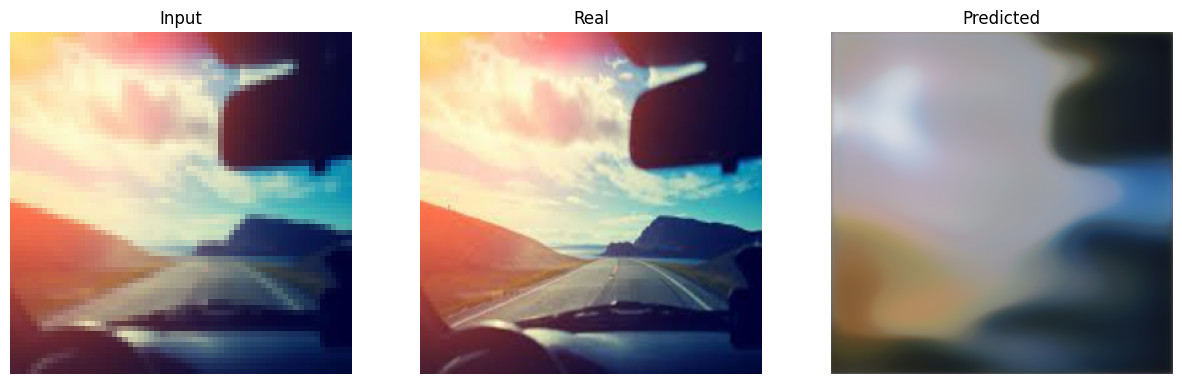

-----------------------------------------------------------
| End of epoch   3 | Time: 57.58s | Train psnr   13.773 | Train Loss    0.290 | Valid psnr   16.484 | Valid Loss    0.212 
-----------------------------------------------------------
| epoch   4 |    50/   86 batches | psnr   13.969
-----------------------------------------------------------
| End of epoch   4 | Time: 56.79s | Train psnr   14.087 | Train Loss    0.282 | Valid psnr   15.944 | Valid Loss    0.215 
-----------------------------------------------------------
| epoch   5 |    50/   86 batches | psnr   14.082


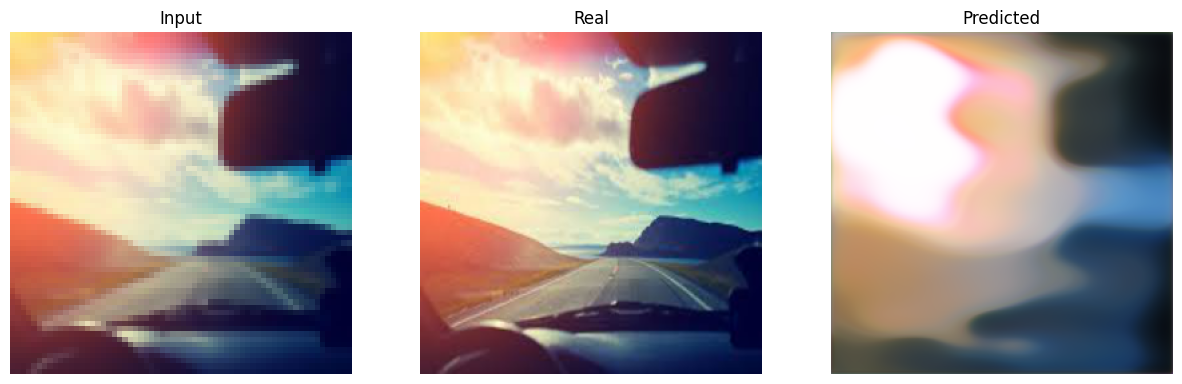

-----------------------------------------------------------
| End of epoch   5 | Time: 57.52s | Train psnr   14.227 | Train Loss    0.277 | Valid psnr   16.655 | Valid Loss    0.211 
-----------------------------------------------------------
| epoch   6 |    50/   86 batches | psnr   14.030


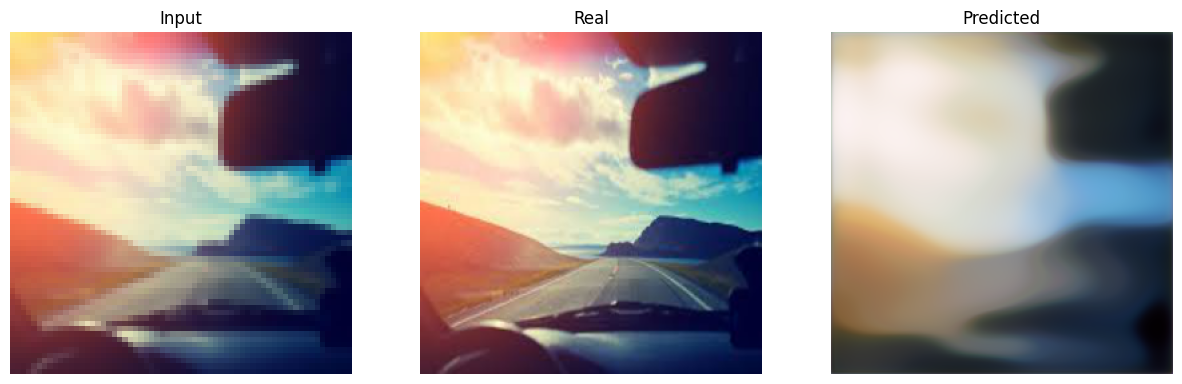

-----------------------------------------------------------
| End of epoch   6 | Time: 57.65s | Train psnr   13.942 | Train Loss    0.281 | Valid psnr   16.868 | Valid Loss    0.196 
-----------------------------------------------------------
| epoch   7 |    50/   86 batches | psnr   14.525
-----------------------------------------------------------
| End of epoch   7 | Time: 56.73s | Train psnr   13.317 | Train Loss    0.281 | Valid psnr   14.993 | Valid Loss    0.250 
-----------------------------------------------------------
| epoch   8 |    50/   86 batches | psnr   13.978


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model_noskip = SR_Unet_NoSkip().to(device)
SR_unet_model_noskip.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model_noskip.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model_noskip, metrics = train(
    SR_unet_model_noskip, 'SR_unet_model_noskip', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model_noskip, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model_noskip, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model_noskip, test_loader, device)

#### Unet

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model = SR_Unet().to(device)
SR_unet_model.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model, metrics = train(
    SR_unet_model, 'SR_unet_model', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model, test_loader, device)